# Import Library

In [1]:
# Import Library
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter
import joblib

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc,roc_auc_score

# Model Performance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize



# Data Preparation

In [ ]:

file_path = r"..\Pre_Emotion_Dataset\8_Lemmatization_new.csv"
df = pd.read_csv(file_path)

print("Columns in the dataset:", df.columns)

# Word Embedding---------------------------------------------------------------------------------------------------
max_words = 20000  
max_len = 100 

X = df['text'].astype(str).values

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X) 
X_seq = tokenizer.texts_to_sequences(X) 
X_padding = pad_sequences(X_seq, maxlen=max_len) 

Y = df['label'].values  
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Train Test Split -------------------------------------------------------------------------------------------------------------------------------
x_train, x_test, y_train, y_test = train_test_split(X_padding, Y, test_size=0.3, stratify=Y,random_state=42)

print("X_train shape:", x_train.shape)
print("Y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("Y_test shape:", y_test.shape)

# Resampling ---------------------------------------------------------------------------------------------------------------------------------
print("Class distribution before resampling:", Counter(Y))

undersampler = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = undersampler.fit_resample(x_train,y_train)

print("Class distribution after resampling:", Counter(y_train_resampled))
print(f"Number of training samples after resampling: {x_train_resampled.shape[0]}")
print("Class distribution (30% test set):", Counter(y_test))


Columns in the dataset: Index(['text', 'label'], dtype='object')
X_train shape: (165180, 100)
Y_train shape: (165180,)
X_test shape: (70792, 100)
Y_test shape: (70792,)
Class distribution before resampling: Counter({0: 135635, 1: 54694, 2: 45643})
Class distribution after resampling: Counter({0: 31950, 1: 31950, 2: 31950})
Number of training samples after resampling: 95850
Class distribution (30% test set): Counter({0: 40691, 1: 16408, 2: 13693})


# Bi-LSTM 

In [3]:
MAX_VOCAB_SIZE =20000  
MAX_SEQUENCE_LENGTH = 100 
EMBEDDING_DIM = 100

model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(3, activation='softmax')  
])

optimizer=Adam(learning_rate=0.003)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    x_train_resampled,
    y_train_resampled,
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)
model.summary()

# Save the model
model.save("1_LSTM_Emotion_model.h5")
joblib.dump(history.history, "1_LSTM_Emotion_history.pkl")
print("Model saved successfully!")

Epoch 1/10


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2996/2996 ━━━━━━━━━━━━━━━━━━━━ 521s 172ms/step - accuracy: 0.8227 - loss: 0.3778 - val_accuracy: 0.9800 - val_loss: 0.0516
Epoch 2/10
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 507s 169ms/step - accuracy: 0.9760 - loss: 0.0604 - val_accuracy: 0.9794 - val_loss: 0.0492
Epoch 3/10
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 624s 208ms/step - accuracy: 0.9794 - loss: 0.0469 - val_accuracy: 0.9767 - val_loss: 0.0562
Epoch 4/10
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 632s 211ms/step - accuracy: 0.9823 - loss: 0.0419 - val_accuracy: 0.9816 - val_loss: 0.0476
Epoch 5/10
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 835s 279ms/step - accuracy: 0.9832 - loss: 0.0391 - val_accuracy: 0.9809 - val_loss: 0.0507
Epoch 6/10
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 522s 174ms/step - accuracy: 0.9830 - loss: 0.0342 - val_accuracy: 0.9803 - val_loss: 0.0562
Epoch 7/10
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 537s 179ms/step - accuracy: 0.9842 - loss: 0.0328 - val_accuracy: 0.9804 - val_loss: 0.0663


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,323,467 (27.94 MB)

 Trainable params: 2,441,155 (9.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,882,312 (18.62 MB)

Model saved successfully!


## Evaluate 

In [4]:
# Evaluate Model ---------------------------------------------------------------------------------------------------------------------\\\

train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

y_pred_prob = model.predict(x_test) 
y_pred = np.argmax(y_pred_prob, axis=1)  

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(y_test, y_pred, average='weighted') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred, average='weighted')
print(f"📌 Recall: {recall:.4f}")

roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")  
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

2996/2996 ━━━━━━━━━━━━━━━━━━━━ 188s 63ms/step - accuracy: 0.9884 - loss: 0.0230
2213/2213 ━━━━━━━━━━━━━━━━━━━━ 115s 52ms/step - accuracy: 0.9819 - loss: 0.0458
2213/2213 ━━━━━━━━━━━━━━━━━━━━ 102s 46ms/step

📌 Train Accuracy: 0.9847
📌 Test Accuracy: 0.9816

📌 Weighted F1 Score: 0.9817
📌 Micro F1 Score: 0.9816
📌 Macro F1 Score: 0.9742

📌 Precision: 0.9821
📌 Recall: 0.9816

📌Test ROC AUC: 0.9992

📌 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     40691
           1       0.98      0.95      0.97     16408
           2       0.94      0.99      0.96     13693

    accuracy                           0.98     70792
   macro avg       0.97      0.98      0.97     70792
weighted avg       0.98      0.98      0.98     70792


📌 Confusion Matrix:
[[40385   204   102]
 [   50 15594   764]
 [   71   109 13513]]


## Learning Curve

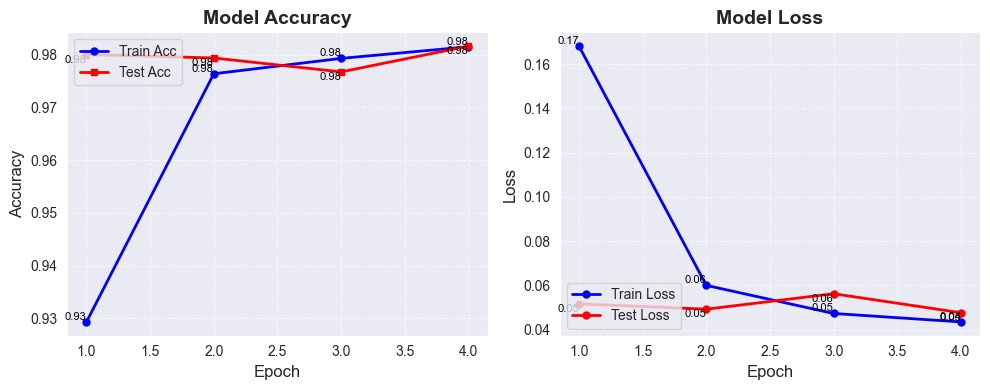

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy'][:4]
val_acc = history.history['val_accuracy'][:4]
loss = history.history['loss'][:4]
val_loss = history.history['val_loss'][:4]
epochs = range(1, len(accuracy) + 1 )


sns.set_style("darkgrid") 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Test Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Test Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()


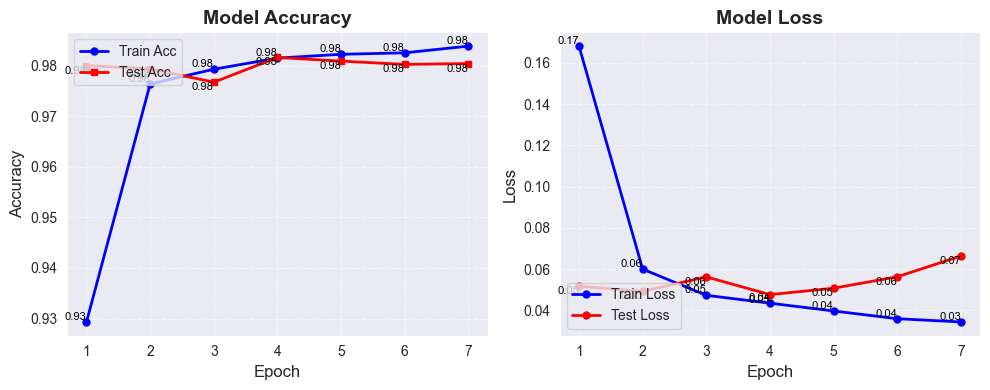

## roc_curve

2996/2996 ━━━━━━━━━━━━━━━━━━━━ 132s 44ms/step - accuracy: 0.9884 - loss: 0.0230
2213/2213 ━━━━━━━━━━━━━━━━━━━━ 91s 41ms/step - accuracy: 0.9819 - loss: 0.0458
2213/2213 ━━━━━━━━━━━━━━━━━━━━ 88s 40ms/step


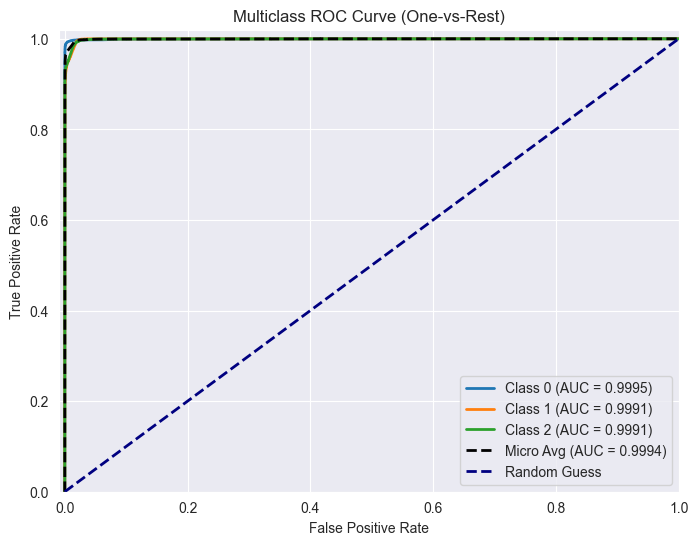

In [7]:
train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

y_pred_prob = model.predict(x_test) 
num_classes = 3

y_test_bin = label_binarize(y_test, classes=[0, 1, 2]) 
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='black', linestyle='--', lw=2, label=f'Micro Avg (AUC = {roc_auc_micro:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()


## confusion_matrix

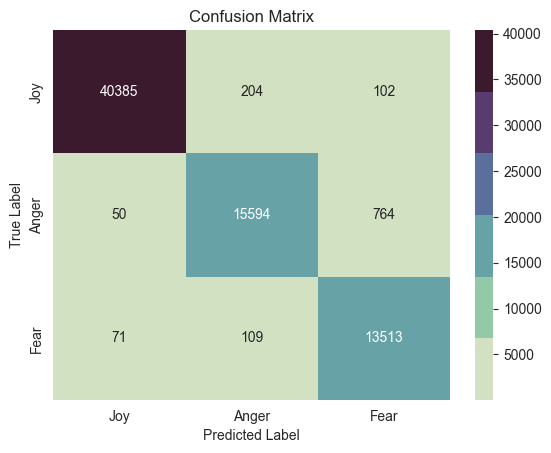

In [9]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap =sns.color_palette("ch:start=1,rot=-.9"),
            xticklabels=['Joy', 'Anger', 'Fear'], 
            yticklabels=['Joy', 'Anger', 'Fear'])

plt.xlabel("Predicted Label") 
plt.ylabel("True Label")  
plt.title("Confusion Matrix") 
plt.show()
